# Part A

In [2]:
# Install required packages
!pip install wandb pytorch-lightning

In [3]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, SubsetRandomSampler
import torchvision.transforms as transforms

from torchvision.datasets import ImageFolder
from pytorch_lightning import LightningModule, LightningDataModule, Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import WandbLogger
import wandb
import matplotlib.pyplot as plt
from collections import defaultdict
import math

# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed()

# Configure device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [17]:
class CustomCNN(LightningModule):
    def __init__(self, 
                 num_classes=10,
                 filter_counts=[32, 32, 64, 64, 128],
                 filter_sizes=[3, 3, 3, 3, 3],
                 activation='relu',
                 dense_neurons=512,
                 input_channels=3,
                 input_size=244,
                 dropout_rate=0.5,
                 learning_rate=0.001,
                 batch_norm=False):
        """
        Custom CNN architecture with flexible hyperparameters
        
        Args:
            num_classes (int): Number of output classes
            filter_counts (list): Number of filters in each conv layer
            filter_sizes (list): Size of filters in each conv layer
            activation (str): Activation function ('relu', 'gelu', 'silu', 'mish')
            dense_neurons (int): Number of neurons in the dense layer
            input_channels (int): Number of input channels (3 for RGB)
            input_size (int): Size of input images (assumes square)
            dropout_rate (float): Dropout rate
            learning_rate (float): Learning rate for optimizer
            batch_norm (bool): Whether to use batch normalization
        """
        super().__init__()
        self.save_hyperparameters()
        
        # Configure activation function
        if activation == 'relu':
            self.activation = nn.ReLU()
        elif activation == 'gelu':
            self.activation = nn.GELU()
        elif activation == 'silu':
            self.activation = nn.SiLU()
        elif activation == 'mish':
            self.activation = nn.Mish()
        else:
            self.activation = nn.ReLU()
        
        # Build the network
        self.conv_layers = nn.ModuleList()
        
        # Calculate feature map sizes for computational analysis
        feature_size = input_size
        feature_sizes = [feature_size]
        
        # First convolutional block
        in_channels = input_channels
        for i in range(5):
            out_channels = filter_counts[i]
            filter_size = filter_sizes[i]
            
            # Create convolutional block
            conv_block = []
            
            # Convolutional layer
            conv_block.append(nn.Conv2d(in_channels, out_channels, kernel_size=filter_size, padding=filter_size//2))
            
            # Batch normalization (optional)
            if batch_norm:
                conv_block.append(nn.BatchNorm2d(out_channels))
            
            # Activation
            conv_block.append(self.activation)
            
            # Max pooling
            conv_block.append(nn.MaxPool2d(kernel_size=2, stride=2))
            
            # Add block to model
            self.conv_layers.append(nn.Sequential(*conv_block))
            
            # Update feature size (divided by 2 due to max pooling)
            feature_size = feature_size // 2
            feature_sizes.append(feature_size)
            
            # Update channels for next layer
            in_channels = out_channels
        
        # Calculate flattened features size
        self.flattened_size = filter_counts[-1] * feature_size * feature_size
        
        # Classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(dropout_rate),
            nn.Linear(self.flattened_size, dense_neurons),
            self.activation,
            nn.Dropout(dropout_rate),
            nn.Linear(dense_neurons, num_classes)
        )
        
        # Store additional parameters
        self.learning_rate = learning_rate
        self.num_classes = num_classes
        self.filter_counts = filter_counts
        self.filter_sizes = filter_sizes
        self.feature_sizes = feature_sizes
        
        # Calculate parameters and computations
        self.total_params = self.calculate_total_params()
        self.total_computations = self.calculate_total_computations()
        
        # For storing test predictions - needed for visualization
        self.test_predictions = []
        self.test_targets = []
        self.test_images = []
        
    def forward(self, x):
        """Forward pass through the network"""
        # Pass through convolutional layers
        for conv_layer in self.conv_layers:
            x = conv_layer(x)
        
        # Pass through classifier
        return self.classifier(x)
    
    def calculate_total_params(self):
        """
        Calculate the total number of parameters in the network
        This answers Question 1: Total parameters with m filters of size k×k and n neurons
        """
        total = 0
        
        # Convolutional layers parameters
        input_channels = 3
        for i in range(5):
            output_channels = self.filter_counts[i]
            filter_size = self.filter_sizes[i]
            
            # Weight parameters: out_channels * in_channels * filter_height * filter_width
            params = output_channels * input_channels * filter_size * filter_size
            # Bias parameters: out_channels
            params += output_channels
            
            total += params
            input_channels = output_channels
        
        # Dense layer parameters
        # First dense layer: flattened_size * dense_neurons + dense_neurons (bias)
        total += self.flattened_size * self.hparams.dense_neurons + self.hparams.dense_neurons
        # Output layer: dense_neurons * num_classes + num_classes (bias)
        total += self.hparams.dense_neurons * self.num_classes + self.num_classes
        
        return total
    
    def calculate_total_computations(self):
        """
        Calculate the total number of computations in the network
        This answers Question 1: Total computations with m filters of size k×k and n neurons
        """
        total = 0
        
        # Convolutional layers computations
        input_channels = 3
        for i in range(5):
            output_channels = self.filter_counts[i]
            filter_size = self.filter_sizes[i]
            feature_size = self.feature_sizes[i]
            
            # Convolution computations:
            # out_channels * in_channels * filter_height * filter_width * feature_height * feature_width
            comp = output_channels * input_channels * filter_size * filter_size * feature_size * feature_size
            
            total += comp
            input_channels = output_channels
        
        # Dense layer computations
        # First dense layer: flattened_size * dense_neurons
        total += self.flattened_size * self.hparams.dense_neurons
        # Output layer: dense_neurons * num_classes
        total += self.hparams.dense_neurons * self.num_classes
        
        return total
    
    def formula_parameter_count(self, m, k, n):
        """
        Formula for the total parameter count in terms of m, k, n
        m: number of filters in each layer
        k: size of filters (k×k)
        n: number of neurons in dense layer
        """
        # For simplicity, assume all conv layers have m filters of size k×k
        # Layer 1: m filters, each with 3*k*k weights + m biases
        layer1_params = m * (3 * k * k + 1)
        
        # Layer 2-5: m filters, each with m*k*k weights + m biases
        other_layers_params = 4 * m * (m * k * k + 1)
        
        # Calculate feature map size after 5 pooling layers (size/32)
        final_feature_size = self.hparams.input_size // 32
        
        # Feature map size after 5 layers
        flattened_size = m * final_feature_size * final_feature_size
        
        # Dense layer: flattened_size * n + n biases
        dense_layer_params = flattened_size * n + n
        
        # Output layer: n * num_classes + num_classes biases
        output_layer_params = n * self.num_classes + self.num_classes
        
        return layer1_params + other_layers_params + dense_layer_params + output_layer_params
    
    def formula_computation_count(self, m, k, n):
        """
        Formula for the total computation count in terms of m, k, n
        m: number of filters in each layer
        k: size of filters (k×k)
        n: number of neurons in dense layer
        """
        total_comp = 0
        input_size = self.hparams.input_size
        
        # Layer 1: m filters, each 3*k*k computations per output position
        layer1_comp = m * 3 * k * k * input_size * input_size
        total_comp += layer1_comp
        
        # Update input size after pooling
        input_size //= 2
        
        # Layers 2-5
        for i in range(4):
            layer_comp = m * m * k * k * input_size * input_size
            total_comp += layer_comp
            input_size //= 2
        
        # Feature map size after 5 layers
        flattened_size = m * input_size * input_size
        
        # Dense layer: flattened_size * n multiplications
        dense_layer_comp = flattened_size * n
        
        # Output layer: n * num_classes multiplications
        output_layer_comp = n * self.num_classes
        
        return total_comp + dense_layer_comp + output_layer_comp
    
    def configure_optimizers(self):
        """Configure optimizer"""
        optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer
    
    def training_step(self, batch, batch_idx):
        """Training step"""
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        
        # Calculate accuracy
        preds = torch.argmax(logits, dim=1)
        acc = (preds == y).float().mean()
        
        # Log metrics
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('train_acc', acc, on_step=False, on_epoch=True, prog_bar=True)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        """Validation step"""
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        
        # Calculate accuracy
        preds = torch.argmax(logits, dim=1)
        acc = (preds == y).float().mean()
        
        # Log metrics
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)
        
        return loss
    
    def test_step(self, batch, batch_idx):
        """Test step"""
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        
        # Calculate accuracy
        preds = torch.argmax(logits, dim=1)
        acc = (preds == y).float().mean()
        
        # Log metrics
        self.log('test_loss', loss, prog_bar=True)
        self.log('test_acc', acc, prog_bar=True)
        
        # Store images, predictions and targets for later visualization
        # Use detach to prevent memory leaks
        self.test_predictions.append(preds.detach().cpu())
        self.test_targets.append(y.detach().cpu())
        self.test_images.append(x.detach().cpu())
        
        return {'loss': loss, 'preds': preds, 'targets': y}
    
    def on_test_epoch_end(self):
        """Process and visualize test results at the end of testing"""
        if not self.test_predictions:
            return
        
        # Concatenate all predictions, targets, and images
        all_preds = torch.cat(self.test_predictions)
        all_targets = torch.cat(self.test_targets)
        all_images = torch.cat(self.test_images)
        
        # Calculate accuracy
        accuracy = (all_preds == all_targets).float().mean().item()
        print(f"Test accuracy: {accuracy:.4f}")
        
        # Visualize test predictions in a 10×3 grid
        self.visualize_test_predictions(all_images, all_preds, all_targets)
        
        # Visualize first layer filters
        self.visualize_first_layer_filters()
        
        # Perform guided backpropagation on last convolutional layer
        if len(all_images) > 0:
            # Take a single image for guided backprop
            sample_image = all_images[0].unsqueeze(0).to(self.device)
            self.visualize_guided_backprop(sample_image)
        
        # Clear stored test data to free memory
        self.test_predictions = []
        self.test_targets = []
        self.test_images = []
    
    def visualize_test_predictions(self, images, predictions, targets):
        """
        Visualize test images with predictions in a 10×3 grid
        This addresses Question 4: Providing a 10×3 grid of test images and predictions
        """
        # Create figure with 10×3 grid
        fig, axes = plt.subplots(10, 3, figsize=(15, 30))
        
        # Get class names if available
        class_names = None
        if hasattr(self.trainer, 'datamodule') and hasattr(self.trainer.datamodule, 'test_dataset'):
            if hasattr(self.trainer.datamodule.test_dataset, 'classes'):
                class_names = self.trainer.datamodule.test_dataset.classes
        
        # Use minimum of 30 samples or available samples
        num_samples = min(30, len(images))
        
        for i in range(num_samples):
            row, col = i // 3, i % 3
            
            # Get image
            img = images[i].numpy().transpose(1, 2, 0)
            
            # De-normalize image
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            img = std * img + mean
            img = np.clip(img, 0, 1)
            
            # Get predicted and target class names
            pred = predictions[i].item()
            target = targets[i].item()
            
            # Use class names if available, otherwise use class indices
            pred_name = class_names[pred] if class_names else f"Class {pred}"
            target_name = class_names[target] if class_names else f"Class {target}"
            
            # Display image
            axes[row, col].imshow(img)
            
            # Set title with color: green if correct, red if wrong
            color = 'green' if pred == target else 'red'
            axes[row, col].set_title(f"Pred: {pred_name}\nTrue: {target_name}", color=color)
            axes[row, col].axis('off')
        
        plt.tight_layout()
        plt.savefig('test_predictions_grid.png')
        wandb.log({"test_predictions_grid": wandb.Image(fig)})
        plt.close(fig)
    
    def visualize_first_layer_filters(self):
        """
        Visualize filters in the first convolutional layer
        This addresses the optional part of Question 4
        """
        # Get weights of the first convolutional layer
        filters = self.conv_layers[0][0].weight.data.cpu()
        
        # Number of filters in the first layer
        num_filters = filters.shape[0]
        grid_size = int(np.ceil(np.sqrt(num_filters)))
        
        # Create figure for the grid
        fig, axes = plt.subplots(grid_size, grid_size, figsize=(15, 15))
        
        # Plot each filter
        for i, ax in enumerate(axes.flat):
            if i < num_filters:
                # Get the filter
                filter_weights = filters[i]
                
                # Normalize for better visualization
                # Convert to numpy and transpose to (H, W, C)
                f_np = filter_weights.permute(1, 2, 0).numpy()
                
                # Normalize to [0, 1]
                f_np = (f_np - f_np.min()) / (f_np.max() - f_np.min() + 1e-8)
                
                # Display the filter
                ax.imshow(f_np)
                ax.set_title(f"Filter {i+1}")
            
            # Turn off axis for all subplots
            ax.axis('off')
        
        plt.tight_layout()
        plt.savefig('first_layer_filters.png')
        wandb.log({"first_layer_filters": wandb.Image(fig)})
        plt.close(fig)
    
    def visualize_guided_backprop(self, input_image):
        """
        Apply guided back-propagation on neurons in the last conv layer
        This addresses the optional part of Question 4
        
        Args:
            input_image: Single input image tensor [1, C, H, W]
        """
        self.eval()  # Set model to evaluation mode
        
        # Skip guided backprop if running on CPU as it can be problematic
        if not torch.cuda.is_available():
            print("Skipping guided backpropagation visualization as it may be unstable on CPU")
            return
        
        try:
            # We'll visualize 10 neurons from the last conv layer (CONV5)
            layer_idx = 4  # 5th layer (0-indexed)
            num_neurons = 10
            
            # Create a copy of the image that requires gradient
            image = input_image.clone().detach()
            image.requires_grad_(True)
            
            # Forward pass through each layer until the target layer
            activations = None
            x = image
            
            # Store hooks for guided backprop
            handles = []
            
            # Define hook for backward pass
            def backward_hook_fn(module, grad_input, grad_output):
                # In guided backprop, we only pass positive gradients to positive activations
                if isinstance(module, (nn.ReLU, nn.GELU, nn.SiLU, nn.Mish)):
                    return (torch.clamp(grad_input[0], min=0.0),)
            
            # Register hooks for all activation functions
            for layer in self.conv_layers:
                for module in layer:
                    if isinstance(module, (nn.ReLU, nn.GELU, nn.SiLU, nn.Mish)):
                        handle = module.register_backward_hook(backward_hook_fn)
                        handles.append(handle)
            
            # Forward pass to the target layer
            for i, layer in enumerate(self.conv_layers):
                if i < layer_idx:
                    x = layer(x)
                elif i == layer_idx:
                    # For the target layer, we need to get activations before the activation function
                    for j, module in enumerate(layer):
                        x = module(x)
                        if isinstance(module, nn.Conv2d):
                            # Store activations after conv but before activation
                            activations = x.clone()
            
            # If no activations were captured, return
            if activations is None:
                print("Failed to capture activations")
                for handle in handles:
                    handle.remove()
                return
            
            # Create figure for guided backprop visualizations
            fig, axes = plt.subplots(1, min(num_neurons, activations.shape[1]), figsize=(20, 4))
            
            # Get the number of channels in the activations (number of filters in the conv layer)
            num_channels = activations.shape[1]
            num_neurons = min(num_neurons, num_channels)
            
            for i in range(num_neurons):
                # Zero gradients
                if image.grad is not None:
                    image.grad.zero_()
                
                # Create a gradient target that selects only the current neuron
                grad_target = torch.zeros_like(activations)
                
                # Set the gradient for a specific neuron - check if the activations have a gradient function
                if activations.requires_grad:
                    grad_target[0, i] = 1.0  # Just use 1.0 instead of activations[0, i].sum()
                    
                    # Backward pass
                    activations.backward(gradient=grad_target, retain_graph=True)
                    
                    # Get gradients with respect to the input image
                    if image.grad is not None:
                        gradients = image.grad.clone().detach().cpu().numpy()[0]
                        
                        # Convert to RGB image
                        gradients = np.transpose(gradients, (1, 2, 0))
                        
                        # Take absolute value and normalize for visualization
                        gradients = np.abs(gradients)
                        gradients = (gradients - gradients.min()) / (gradients.max() - gradients.min() + 1e-8)
                        
                        # Plot
                        if num_neurons == 1:
                            axes.imshow(gradients)
                            axes.set_title(f"Neuron {i}")
                            axes.axis('off')
                        else:
                            axes[i].imshow(gradients)
                            axes[i].set_title(f"Neuron {i}")
                            axes[i].axis('off')
                    else:
                        print(f"No gradients for neuron {i}")
                else:
                    print("Activations do not require gradients")
            
            plt.tight_layout()
            plt.savefig('guided_backprop.png')
            wandb.log({"guided_backprop": wandb.Image(fig)})
            plt.close(fig)
        
        except Exception as e:
            print(f"Error in guided backpropagation: {e}")
            print("Skipping guided backpropagation visualization")
        
        finally:
            # Remove hooks to prevent memory leaks
            for handle in handles:
                handle.remove()

In [18]:
class iNaturalistDataModule(LightningDataModule):
    def __init__(self, data_dir='/kaggle/input/inaturalist/inaturalist_12K', batch_size=32, num_workers=4, 
                 input_size=244, val_split=0.2, augmentation=False):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.input_size = input_size
        self.val_split = val_split
        self.augmentation = augmentation
        self.class_names = None
        
    def setup(self, stage=None):
        """Setup data transformations and load datasets"""
        # Define transformations
        if self.augmentation:
            train_transform = transforms.Compose([
                transforms.RandomResizedCrop(self.input_size),
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(10),
                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])
        else:
            train_transform = transforms.Compose([
                transforms.Resize((self.input_size, self.input_size)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])
            
        val_transform = transforms.Compose([
            transforms.Resize((self.input_size, self.input_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        
        # Load datasets
        train_dir = os.path.join(self.data_dir, 'train')
        test_dir = os.path.join(self.data_dir, 'val')  # Using val folder as test set
        
        self.train_dataset = ImageFolder(root=train_dir, transform=train_transform)
        self.test_dataset = ImageFolder(root=test_dir, transform=val_transform)
        
        # Store class names
        self.class_names = self.train_dataset.classes
        
        # Split train set into train and validation - using stratified sampling
        dataset_size = len(self.train_dataset)
        indices = list(range(dataset_size))
        
        # Create stratified split
        class_indices = defaultdict(list)
        for idx, (_, label) in enumerate(self.train_dataset.samples):
            class_indices[label].append(idx)
        
        train_indices = []
        val_indices = []
        
        for class_idx, indices in class_indices.items():
            np.random.shuffle(indices)
            split_idx = int(len(indices) * (1 - self.val_split))
            train_indices.extend(indices[:split_idx])
            val_indices.extend(indices[split_idx:])
        
        # Create samplers for train and validation sets
        self.train_sampler = SubsetRandomSampler(train_indices)
        self.val_sampler = SubsetRandomSampler(val_indices)
        
    def train_dataloader(self):
        """Return train dataloader"""
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            sampler=self.train_sampler,
            num_workers=self.num_workers
        )
    
    def val_dataloader(self):
        """Return validation dataloader"""
        return DataLoader(
            self.train_dataset,  # Use the original train dataset with validation indices
            batch_size=self.batch_size,
            sampler=self.val_sampler,
            num_workers=self.num_workers
        )
    
    def test_dataloader(self):
        """Return test dataloader"""
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers
        )

In [19]:
def setup_wandb_sweep():
    """
    Define sweep configuration for hyperparameter tuning
    """
    sweep_config = {
        'method': 'bayes',
        'metric': {'name': 'val_acc', 'goal': 'maximize'},
        'parameters': {
            'filter_counts_strategy': {'values': ['same', 'doubling', 'halving']},
            'base_filters':           {'values': [16, 32, 64]},
            'filter_size':            {'values': [3, 5]},
            'activation':             {'values': ['relu', 'gelu', 'silu', 'mish']},
            'dense_neurons':          {'values': [128, 256, 384, 512]},
            'dropout_rate':           {'values': [0.2, 0.3, 0.5]},
            'learning_rate':          {'values': [0.0001, 0.001]},
            'batch_norm':             {'values': [True, False]},
            'batch_size':             {'values': [16, 32]},
            'augmentation':           {'values': [True, False]},
        }
    }
    return sweep_config

def train_model_sweep():
    """
    Training function for sweep
    This trains models during hyperparameter search
    """
    # Initialize wandb
    wandb.init()
    
    # Get hyperparameters from wandb
    config = wandb.config
    
    # Generate filter counts based on strategy
    if config.filter_counts_strategy == 'same':
        filter_counts = [config.base_filters] * 5
    elif config.filter_counts_strategy == 'doubling':
        filter_counts = [config.base_filters * (2**i) for i in range(5)]
    elif config.filter_counts_strategy == 'halving':
        filter_counts = [config.base_filters * (2**(4-i)) for i in range(5)]
    
    # Generate filter sizes
    filter_sizes = [config.filter_size] * 5
    
    # Create data module
    data_module = iNaturalistDataModule(
        batch_size=config.batch_size,
        augmentation=config.augmentation
    )
    data_module.setup()
    
    # Create model with hyperparameters
    model = CustomCNN(
        num_classes=10,  # Assuming 10 classes in iNaturalist subset
        filter_counts=filter_counts,
        filter_sizes=filter_sizes,
        activation=config.activation,
        dense_neurons=config.dense_neurons,
        dropout_rate=config.dropout_rate,
        learning_rate=config.learning_rate,
        batch_norm=config.batch_norm
    )
    
    # Log model information
    wandb.log({
        'total_params': model.total_params,
        'total_computations': model.total_computations
    })
    
    # Setup callbacks
    callbacks = [
        ModelCheckpoint(
            monitor='val_acc',
            filename='best-{epoch:02d}-{val_acc:.4f}',
            save_top_k=1,
            mode='max'
        ),
        EarlyStopping(
            monitor='val_acc',
            patience=5,
            mode='max'
        )
    ]
    
    # Setup wandb logger
    wandb_logger = WandbLogger()
    
    # Create trainer
    trainer = Trainer(
        max_epochs=15,  # Train longer for better results
        accelerator='gpu' if torch.cuda.is_available() else 'cpu',
        devices=1,
        callbacks=callbacks,
        logger=wandb_logger,
        log_every_n_steps=10
    )
    
    # Train model
    trainer.fit(model, data_module.train_dataloader(), data_module.val_dataloader())
    
    # Get best validation accuracy
    best_val_acc = trainer.callback_metrics.get('val_acc', 0)
    
    # Log additional metrics
    wandb.log({
        'best_val_acc': best_val_acc
    })
    
    return model, best_val_acc

def run_sweep(project_name="inaturalist_cnn_sweep"):
    """
    Run the sweep
    This addresses Question 2: Using the sweep feature in wandb
    """    
    # Setup sweep
    sweep_config = setup_wandb_sweep()
    
    # Create sweep
    sweep_id = wandb.sweep(sweep_config, project=project_name)
    
    # Run sweep
    wandb.agent(sweep_id, function=train_model_sweep, count=3)
    return sweep_id

def analyze_sweep_results(entity="mm21b044-indian-institute-of-technology-madras", project="inaturalist_cnn_sweep", metric='best_val_acc'):
    """
    Analyze all sweep runs in a W&B project to find the best model configuration.

    Args:
        entity (str): W&B username or team name.
        project (str): W&B project name.
        metric (str): Metric to evaluate runs (default: 'best_val_acc').
    """
    api = wandb.Api()
    runs = api.runs(f"{entity}/{project}")

    best_run = None
    best_metric = float('-inf')
    
    # Collect data for correlation analysis
    hyperparams = []
    metrics_values = []
    run_data = []

    for run in runs:
        # Check if the run is part of a sweep
        if run.sweep is not None:
            run_metric = run.summary.get(metric)
            if run_metric is not None:
                # Store data for correlation analysis
                config_dict = dict(run.config)
                config_dict[metric] = run_metric
                run_data.append(config_dict)
                
                # Track best run
                if run_metric > best_metric:
                    best_metric = run_metric
                    best_run = run
    
    # Generate correlation summary table
    if run_data:
        # Convert run data to pandas DataFrame
        import pandas as pd
        import matplotlib.pyplot as plt
        import seaborn as sns
        
        df = pd.DataFrame(run_data)
        
        # Create correlation matrix
        # First, select only numeric columns for correlation
        numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
        if len(numeric_cols) > 1:  # Need at least 2 numeric columns for correlation
            corr_matrix = df[numeric_cols].corr()
            
            # Create heatmap figure
            plt.figure(figsize=(12, 10))
            sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
            plt.title('Correlation of Hyperparameters with Metrics')
            plt.tight_layout()
            
            # Save the figure
            plt.savefig('hyperparameter_correlation.png')
            
            # Log to wandb
            wandb.init(project=project, job_type="analysis", resume=False)
            wandb.log({"hyperparameter_correlation": wandb.Image(plt)})
            
            # Create a specific correlation table for the target metric
            if metric in numeric_cols:
                metric_corr = corr_matrix[metric].sort_values(ascending=False)
                print("\nCorrelation with", metric)
                print(metric_corr)
                
                # Create a bar plot for metric correlation
                plt.figure(figsize=(10, 6))
                metric_corr.drop(metric).plot(kind='bar')
                plt.title(f'Correlation of Hyperparameters with {metric}')
                plt.ylabel('Correlation Coefficient')
                plt.tight_layout()
                
                # Save and log
                plt.savefig('metric_correlation.png')
                wandb.log({"metric_correlation": wandb.Image(plt)})
                
                # You can also log this as a table
                metric_corr_df = pd.DataFrame(metric_corr)
                wandb.log({"metric_correlation_table": wandb.Table(dataframe=metric_corr_df.reset_index())})
            
            wandb.finish()
        else:
            print("Not enough numeric columns for correlation analysis")
    
    if best_run:
        print(f"Best run: {best_run.name}")
        print(f"{metric}: {best_metric}")
        print("Hyperparameters:")
        for key, value in best_run.config.items():
            print(f"  {key}: {value}")

        # Save the configuration to a JSON file
        config_dict = dict(best_run.config)
    else:
        print("No sweep runs found with the specified metric.")
        config_dict = {}
    
    return config_dict

In [20]:
def train_best_model(config, data_dir='/kaggle/input/inaturalist/inaturalist_12K', project_name="inaturalist_cnn_final"):
    """
    Train the best model based on sweep results.
    This addresses Question 4: Training and evaluating on test data
    
    Args:
        config (dict): Best hyperparameter configuration
        data_dir (str): Path to dataset directory
        project_name (str): Name of the wandb project
    """
    # Initialize wandb
    wandb.init(project=project_name, config=config)
    
    # Generate filter counts based on strategy
    if config["filter_counts_strategy"] == 'same':
        filter_counts = [config["base_filters"]] * 5
    elif config["filter_counts_strategy"] == 'doubling':
        filter_counts = [config["base_filters"] * (2**i) for i in range(5)]
    elif config["filter_counts_strategy"] == 'halving':
        filter_counts = [config["base_filters"] * (2**(4-i)) for i in range(5)]
    
    # Generate filter sizes
    filter_sizes = [config["filter_size"]] * 5
    
    # Create data module
    data_module = iNaturalistDataModule(
        data_dir=data_dir,
        batch_size=config["batch_size"],
        augmentation=config["augmentation"]
    )
    data_module.setup()
    
    # Create model with best hyperparameters
    model = CustomCNN(
        num_classes=10,  # Assuming 10 classes in iNaturalist subset
        filter_counts=filter_counts,
        filter_sizes=filter_sizes,
        activation=config["activation"],
        dense_neurons=config["dense_neurons"],
        dropout_rate=config["dropout_rate"],
        learning_rate=config["learning_rate"],
        batch_norm=config["batch_norm"]
    )
    
    # Log model information
    wandb.log({
        'total_params': model.total_params,
        'total_computations': model.total_computations,
        'model_summary': str(model)
    })
    
    # Setup callbacks
    callbacks = [
        ModelCheckpoint(
            monitor='val_acc',
            filename='best-{epoch:02d}-{val_acc:.4f}',
            save_top_k=1,
            mode='max'
        )
    ]
    
    # Setup wandb logger
    wandb_logger = WandbLogger(project=project_name)
    
    # Create trainer
    trainer = Trainer(
        max_epochs=30,  # Train longer for final model
        accelerator='gpu' if torch.cuda.is_available() else 'cpu',
        devices=1,
        callbacks=callbacks,
        logger=wandb_logger,
        log_every_n_steps=10
    )
    
    # Train model
    trainer.fit(model, data_module)
    
    # Test model
    test_results = trainer.test(model, data_module.test_dataloader())
    
    return model, test_results[0]['test_acc']

def display_model_architecture(model):
    """
    Display the architecture of the model with parameter counts
    This helps answer Question 1 about parameter and computation counts
    """
    print(f"Model Architecture Summary:")
    print(f"===========================")
    print(f"Total parameters: {model.total_params:,}")
    print(f"Total computations: {model.total_computations:,}")
    print(f"===========================")
    
    # Use the model's built-in formula methods
    base_filter = 32  # Example value
    k = 3  # Example filter size
    n = 512  # Example dense neurons
    
    print(f"Formula for parameter count (with m={base_filter}, k={k}, n={n}):")
    param_count = model.formula_parameter_count(base_filter, k, n)
    print(f"Total parameters by formula: {param_count:,}")
    
    print(f"\nFormula for computation count:")
    comp_count = model.formula_computation_count(base_filter, k, n)
    print(f"Total computations by formula: {comp_count:,}")

In [21]:
def main():
    """
    Main function to run the complete pipeline
    """
    print("Running iNaturalist CNN classifier...")
    
    # Step 1: Run a hyperparameter sweep (Question 2)
    run_sweep_flag = input("Do you want to run a hyperparameter sweep? (y/n): ").lower() == 'y'
    wandb.login(key="e030007b097df00d9a751748294abc8440f932b1")

    if run_sweep_flag:
        print("Running hyperparameter sweep...")
        sweep_id = run_sweep()
        print(f"Sweep completed. Sweep ID: {sweep_id}")
        
        # Step 2: Analyze sweep results (Question 3)
        print("\nAnalyzing sweep results...")
        best_config = analyze_sweep_results()
    else:
        # Use a predefined best configuration if not running sweep
        print("Using predefined best configuration...")
        best_config = {
                    'activation': 'mish',
                    'batch_norm': False,
                    'batch_size': 16,
                    'input_size': 224,
                    'filter_size': 5,
                    'num_classes': 10,
                    'augmentation': False,
                    'base_filters': 64,
                    'dropout_rate': 0.5,
                    'filter_sizes': [5, 5, 5, 5, 5],
                    'dense_neurons': 512,
                    'filter_counts': [64, 64, 64, 64, 64],
                    'learning_rate': 0.0001,
                    'input_channels': 3,
                    'filter_counts_strategy': 'same'}
    
    # Step 3: Train the best model (Question 4)
    print("\nTraining best model with configuration:")
    for key, value in best_config.items():
        print(f"  {key}: {value}")
    
    # Get data directory from user
    data_dir = "/kaggle/input/inaturalist/inaturalist_12K"
    
    # Train best model
    model, test_accuracy = train_best_model(best_config, data_dir)
    
    print(f"\nTraining completed!")
    print(f"Test accuracy: {test_accuracy:.4f}")
    
    # Step 4: Display model architecture (Question 1)
    display_model_architecture(model)
    
    print("\nAll tasks completed successfully!")

Running iNaturalist CNN classifier...


Do you want to run a hyperparameter sweep? (y/n):  y


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Running hyperparameter sweep...
Create sweep with ID: 2v3w6l5x
Sweep URL: https://wandb.ai/mm21b044-indian-institute-of-technology-madras/inaturalist_cnn_sweep/sweeps/2v3w6l5x


wandb: Agent Starting Run: unfpzqn3 with config:
wandb: 	activation: mish
wandb: 	augmentation: False
wandb: 	base_filters: 16
wandb: 	batch_norm: True
wandb: 	batch_size: 32
wandb: 	dense_neurons: 128
wandb: 	dropout_rate: 0.2
wandb: 	filter_counts_strategy: halving
wandb: 	filter_size: 5
wandb: 	learning_rate: 0.001


/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dense_neurons' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_norm' was locked by 'sweep' (ignored update).


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

best_val_acc,▁
epoch,▁▁▁▁▂▂▃▃▃▃▃▃▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇▇██
total_computations,▁
total_params,▁
train_acc,▁▂▃▄▄▄▅▅▅▆▆▇▇██
train_loss,█▇▆▆▆▅▅▄▄▃▃▂▂▁▁
trainer/global_step,▁▁▁▁▂▂▃▃▃▃▃▃▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇▇██
val_acc,▁▃▂▄▅▆▇▆▇▇▇▇█▇▇
val_loss,█▅▇▃▂▁▁▃▁▁▂▂▂▆▃
best_val_acc,0.3625
epoch,14


wandb: Agent Starting Run: g30bmaeu with config:
wandb: 	activation: relu
wandb: 	augmentation: False
wandb: 	base_filters: 32
wandb: 	batch_norm: True
wandb: 	batch_size: 16
wandb: 	dense_neurons: 256
wandb: 	dropout_rate: 0.3
wandb: 	filter_counts_strategy: halving
wandb: 	filter_size: 3
wandb: 	learning_rate: 0.0001


wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dense_neurons' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_norm' was locked by 'sweep' (ignored update).


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

best_val_acc,▁
epoch,▁▁▁▁▂▂▃▃▃▃▃▃▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇▇██
total_computations,▁
total_params,▁
train_acc,▁▂▃▄▄▅▅▆▆▆▇▇███
train_loss,█▇▆▅▅▅▄▄▃▃▂▂▂▁▁
trainer/global_step,▁▁▁▁▂▂▃▃▃▃▃▃▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇▇██
val_acc,▁▃▄▅▅▅▆▇▇▆▅█▇█▇
val_loss,█▇▅▄▄▃▃▂▂▄▄▁▂▁▂
best_val_acc,0.403
epoch,14


wandb: Agent Starting Run: qotbb26n with config:
wandb: 	activation: silu
wandb: 	augmentation: True
wandb: 	base_filters: 64
wandb: 	batch_norm: True
wandb: 	batch_size: 16
wandb: 	dense_neurons: 128
wandb: 	dropout_rate: 0.2
wandb: 	filter_counts_strategy: doubling
wandb: 	filter_size: 5
wandb: 	learning_rate: 0.001


wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dense_neurons' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_norm' was locked by 'sweep' (ignored update).


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

best_val_acc,▁
epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
total_computations,▁
total_params,▁
train_acc,█▆▄▂▂▁▂▄▂▁
train_loss,█▁▁▁▁▁▁▁▂▁
trainer/global_step,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
val_acc,▁▁▆▁█▁▁▁▁▁
val_loss,█▆▂▂▁▂▁▂▂▂
best_val_acc,0.1
epoch,9


Sweep completed. Sweep ID: 2v3w6l5x

Analyzing sweep results...


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1



Correlation with best_val_acc
best_val_acc      1.000000
dropout_rate      0.097027
base_filters      0.086271
batch_size       -0.003634
filter_size      -0.073703
input_size       -0.083143
dense_neurons    -0.223758
learning_rate    -0.579294
num_classes            NaN
input_channels         NaN
Name: best_val_acc, dtype: float64


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


Best run: graceful-sweep-2
best_val_acc: 0.40299999713897705
Hyperparameters:
  activation: relu
  batch_norm: True
  batch_size: 16
  input_size: 244
  filter_size: 3
  num_classes: 10
  augmentation: False
  base_filters: 32
  dropout_rate: 0.3
  filter_sizes: [3, 3, 3, 3, 3]
  dense_neurons: 256
  filter_counts: [512, 256, 128, 64, 32]
  learning_rate: 0.0001
  input_channels: 3
  filter_counts_strategy: halving

Training best model with configuration:
  activation: relu
  batch_norm: True
  batch_size: 16
  input_size: 244
  filter_size: 3
  num_classes: 10
  augmentation: False
  base_filters: 32
  dropout_rate: 0.3
  filter_sizes: [3, 3, 3, 3, 3]
  dense_neurons: 256
  filter_counts: [512, 256, 128, 64, 32]
  learning_rate: 0.0001
  input_channels: 3
  filter_counts_strategy: halving


/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dense_neurons' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_norm' was locked by 'sweep' (ignored update).


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dense_neurons' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_norm' was locked by 'sweep' (ignored update).


Testing: |          | 0/? [00:00<?, ?it/s]

Test accuracy: 0.4405
Activations do not require gradients
Activations do not require gradients
Activations do not require gradients
Activations do not require gradients
Activations do not require gradients
Activations do not require gradients
Activations do not require gradients
Activations do not require gradients
Activations do not require gradients
Activations do not require gradients


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.4404999911785126     │
│         test_loss         │     1.708396553993225     │
└───────────────────────────┴───────────────────────────┘


Training completed!
Test accuracy: 0.4405
Model Architecture Summary:
Total parameters: 1,985,770
Total computations: 19,549,180,416
Formula for parameter count (with m=32, k=3, n=512):
Total parameters by formula: 846,346

Formula for computation count:
Total computations by formula: 234,078,720

All tasks completed successfully!


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


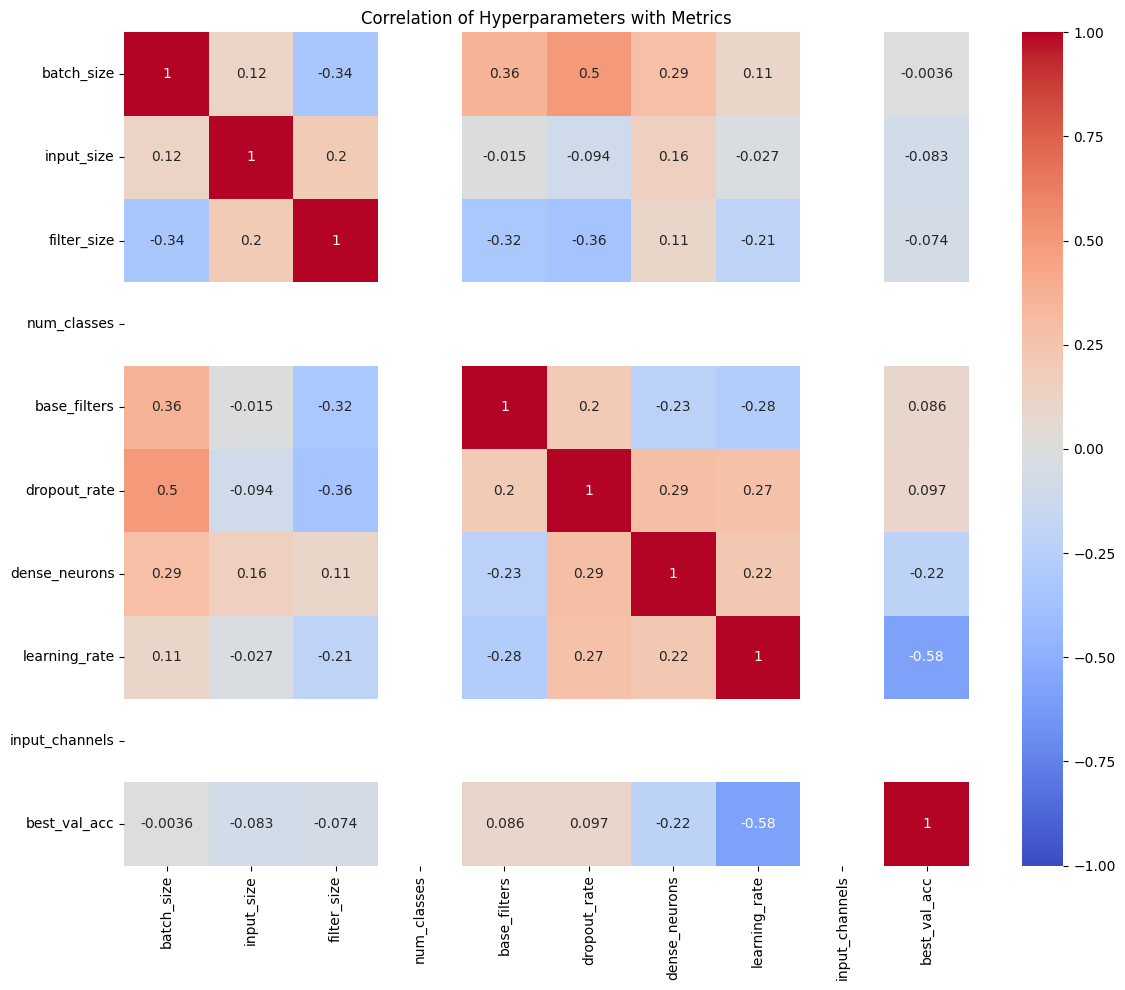

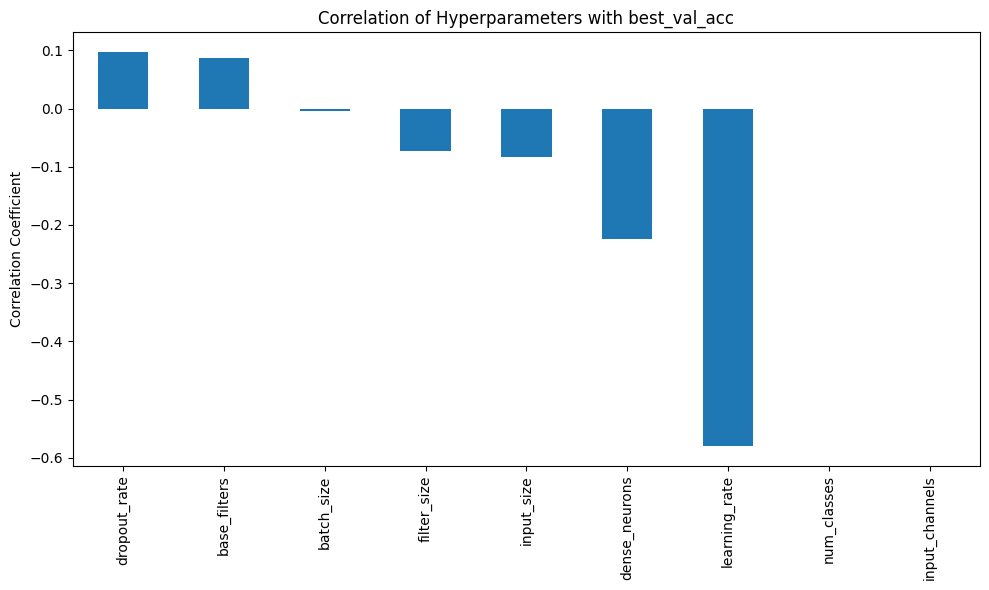

In [22]:
main()

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1



Correlation with best_val_acc
best_val_acc      1.000000
base_filters      0.310160
filter_size       0.049587
dropout_rate      0.025118
input_size       -0.067435
batch_size       -0.084482
dense_neurons    -0.391197
learning_rate    -0.679629
num_classes            NaN
input_channels         NaN
Name: best_val_acc, dtype: float64


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


Best run: fresh-sweep-2
best_val_acc: 0.3964999914169311
Hyperparameters:
  activation: mish
  batch_norm: False
  batch_size: 16
  input_size: 224
  filter_size: 5
  num_classes: 10
  augmentation: False
  base_filters: 64
  dropout_rate: 0.5
  filter_sizes: [5, 5, 5, 5, 5]
  dense_neurons: 512
  filter_counts: [64, 64, 64, 64, 64]
  learning_rate: 0.0001
  input_channels: 3
  filter_counts_strategy: same


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


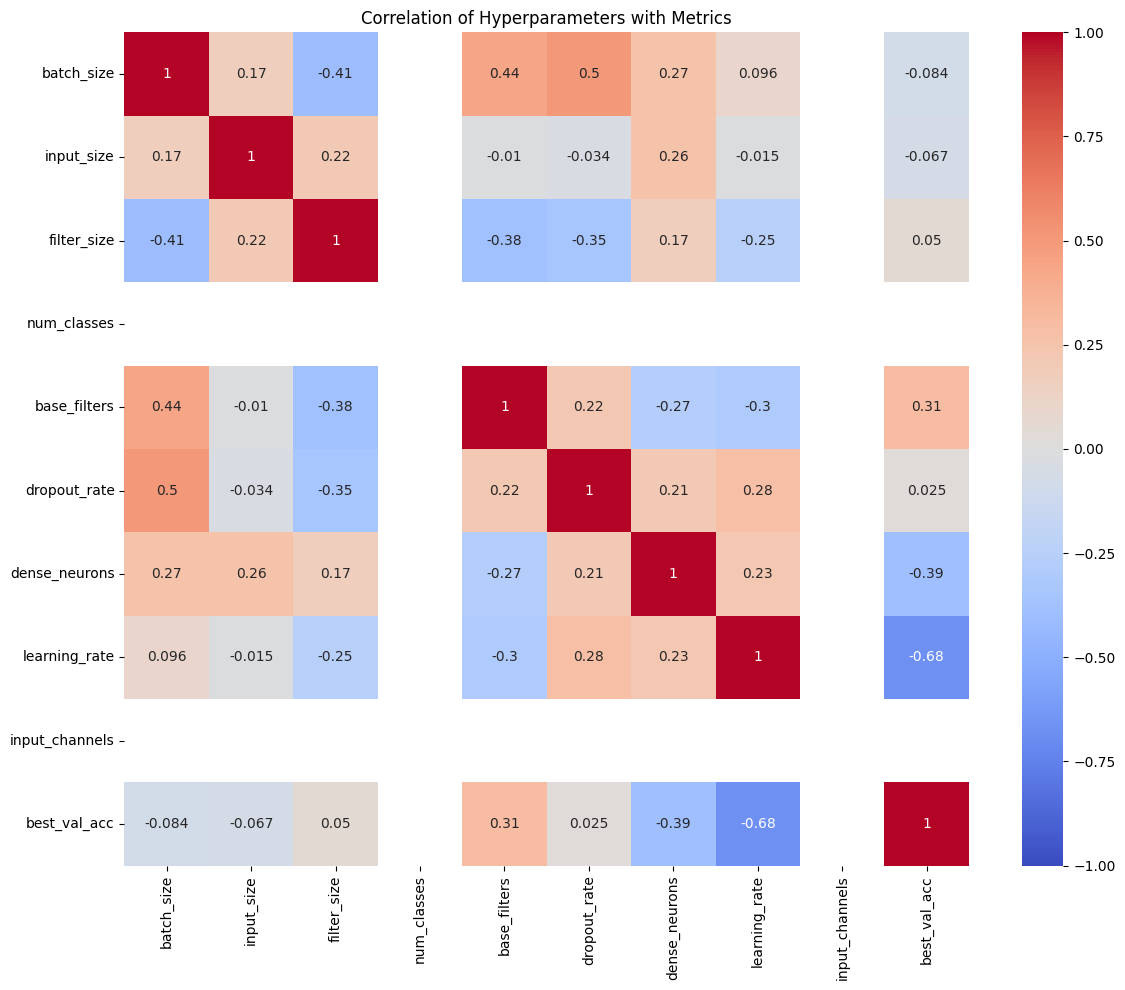

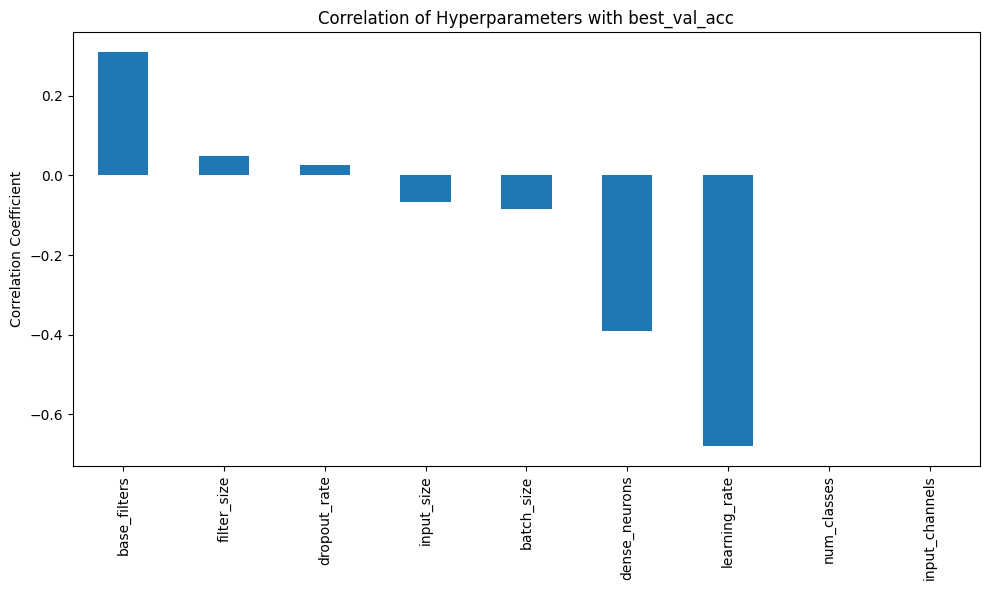

In [16]:
import wandb
best_config = analyze_sweep_results()

# Part B

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
import torchvision.transforms.functional as TF
from PIL import Image
import matplotlib.pyplot as plt
import wandb
import random
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Constants
NUM_CLASSES = 10
BATCH_SIZE = 32
NUM_EPOCHS = 10
LEARNING_RATE = 0.001
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda


In [2]:
# Define paths
TRAIN_DIR = "/kaggle/input/inaturalist/inaturalist_12K/train"
TEST_DIR = "/kaggle/input/inaturalist/inaturalist_12K/val"

# Custom Dataset for iNaturalist
class INaturalistDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        
        self.samples = []
        for class_name in self.classes:
            class_dir = os.path.join(root_dir, class_name)
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                self.samples.append((img_path, self.class_to_idx[class_name]))
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

# Data transformations
# ImageNet normalization values
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Define transformations for training and testing
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet models require 224x224 input
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# Load datasets
train_dataset = INaturalistDataset(TRAIN_DIR, transform=train_transform)

# Split into training and validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

# Load test dataset
test_dataset = INaturalistDataset(TEST_DIR, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

In [3]:
# Updated main function with enhanced wandb logging
def run_experiment(model_name, freeze_strategy, num_classes, train_loader, val_loader, 
                  test_loader, test_dataset, num_epochs=NUM_EPOCHS):
    """Run a complete fine-tuning experiment with comprehensive wandb logging."""
    # Initialize wandb run
    run_name = f"{model_name}_{freeze_strategy}"
    wandb.init(project="inaturalist_fine_tuning", name=run_name, config={
        "model": model_name,
        "freeze_strategy": freeze_strategy,
        "batch_size": BATCH_SIZE,
        "learning_rate": LEARNING_RATE,
        "epochs": num_epochs,
        "num_classes": num_classes
    })
    
    # Load model with specified freezing strategy
    model = load_pretrained_model(model_name=model_name, 
                                 freeze_layers=freeze_strategy, 
                                 num_classes=num_classes)
    
    # Calculate and log trainable parameters
    trainable_params = count_trainable_parameters(model)
    total_params = sum(p.numel() for p in model.parameters())
    wandb.log({
        "trainable_parameters": trainable_params,
        "total_parameters": total_params,
        "percent_trainable": (trainable_params / total_params) * 100
    })
    print(f"Strategy: {freeze_strategy} - Trainable parameters: {trainable_params:,} ({trainable_params/total_params:.2%})")
    
    # Set up optimizer based on strategy
    if freeze_strategy == "none":
        # Different learning rates for pre-trained vs new layers
        params_to_update = []
        params_new = []
        
        for name, param in model.named_parameters():
            if name.startswith('fc') or name.startswith('classifier') or name.startswith('heads'):
                params_new.append(param)
            else:
                params_to_update.append(param)
        
        optimizer = optim.SGD([
            {'params': params_to_update, 'lr': LEARNING_RATE * 0.1},
            {'params': params_new, 'lr': LEARNING_RATE}
        ], momentum=0.9)
    else:
        # Regular optimizer for frozen models
        optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), 
                             lr=LEARNING_RATE, momentum=0.9)
    
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    criterion = nn.CrossEntropyLoss()
    
    # Create a table to log per-epoch metrics
    columns = ["epoch", "train_loss", "train_acc", "val_loss", "val_acc", "learning_rate"]
    metrics_table = wandb.Table(columns=columns)
    
    # Train model
    print(f"Training model: {model_name} with strategy: {freeze_strategy}")
    best_val_acc = 0.0
    best_model_wts = None
    
    # History to track metrics
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0
        
        for inputs, labels in train_loader:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                
                # Backward pass + optimize
                loss.backward()
                optimizer.step()
            
            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        
        if scheduler:
            scheduler.step()
            
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc.item())
        
        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        
        # Validation phase
        model.eval()
        running_loss = 0.0
        running_corrects = 0
        
        for inputs, labels in val_loader:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)
            
            # Forward pass
            with torch.no_grad():
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
            
            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        
        val_loss = running_loss / len(val_loader.dataset)
        val_acc = running_corrects.double() / len(val_loader.dataset)
        
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc.item())
        
        print(f'Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        
        # Add row to metrics table
        curr_lr = optimizer.param_groups[0]['lr']
        metrics_table.add_data(epoch+1, epoch_loss, epoch_acc.item(), val_loss, val_acc.item(), curr_lr)
        
        # Log metrics for this epoch
        wandb.log({
            "epoch": epoch + 1,
            "train_loss": epoch_loss,
            "train_acc": epoch_acc.item(),
            "val_loss": val_loss,
            "val_acc": val_acc.item(),
            "learning_rate": curr_lr
        })
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_wts = model.state_dict().copy()
            model_filename = f'best_model_{model_name}_{freeze_strategy}.pth'
            torch.save(best_model_wts, model_filename)
            print(f"Saved new best model with accuracy: {best_val_acc:.4f}")
            
            # Log best model as artifact
            model_artifact = wandb.Artifact(f"model-{run_name}", type="model")
            model_artifact.add_file(model_filename)
            wandb.log_artifact(model_artifact)
    
    # Log final metrics table
    wandb.log({"training_metrics": metrics_table})
    
    # Load best model and evaluate on test set
    model.load_state_dict(best_model_wts)
    class_names = get_class_names(test_dataset)
    test_loss, test_acc, cm, all_preds, all_labels = evaluate_model(model, test_loader, criterion, class_names, model_name, freeze_strategy)
    
    # Log final test metrics
    wandb.log({
        "final_test_accuracy": test_acc,
        "final_test_loss": test_loss
    })
    
    # Visualize incorrect predictions and log
    visualize_incorrect_predictions(test_dataset, test_loader, model, class_names)
    
    # Create and log training curves
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history['train_acc'], label='Train')
    plt.plot(history['val_acc'], label='Validation')
    plt.title(f'{model_name}_{freeze_strategy} accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history['train_loss'], label='Train')
    plt.plot(history['val_loss'], label='Validation')
    plt.title(f'{model_name}_{freeze_strategy} loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    wandb.log({"training_curves": wandb.Image(plt)})
    plt.savefig(f'training_curves_{freeze_strategy}.png')
    plt.close()
    
    wandb.finish()
    return model, history, test_acc

In [4]:
def get_class_names(dataset):
    """Get the class names from the dataset."""
    return dataset.classes

# Function to load a pre-trained model and modify the last layer
def load_pretrained_model(model_name="resnet50", freeze_layers="all_except_last", num_classes=10):
    """
    Load a pre-trained model and modify it for fine-tuning
    
    Parameters:
        model_name: Name of the model to load (resnet50, vgg16, etc.)
        freeze_layers: Strategy for freezing layers
            - "all_except_last": Freeze all layers except the last layer
            - "none": Don't freeze any layers (full fine-tuning)
            - "first_k": Freeze only the first k layers
            - "all_except_k": Freeze all layers except the last k layers
        num_classes: Number of output classes
        
    Returns:
        model: Modified model ready for fine-tuning
    """
    if model_name == "resnet50":
        model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
        
        # Replace the final fully connected layer
        in_features = model.fc.in_features
        model.fc = nn.Linear(in_features, num_classes)
        
        # Freeze layers according to the strategy
        if freeze_layers == "all_except_last":
            # Freeze all layers except the final fc layer
            for param in model.parameters():
                param.requires_grad = False
            for param in model.fc.parameters():
                param.requires_grad = True
                
        elif freeze_layers == "none":
            # Don't freeze any layers (full fine-tuning)
            pass
            
        elif freeze_layers.startswith("first_"):
            # Freeze the first k layers
            k = int(freeze_layers.split("_")[1])
            layers_to_freeze = list(model.named_children())[:k]
            for name, layer in layers_to_freeze:
                for param in layer.parameters():
                    param.requires_grad = False
                    
        elif freeze_layers.startswith("all_except_"):
            # Freeze all layers except the last k layers
            k = int(freeze_layers.split("_")[2])
            total_layers = len(list(model.named_children()))
            layers_to_freeze = list(model.named_children())[:(total_layers-k)]
            for name, layer in layers_to_freeze:
                for param in layer.parameters():
                    param.requires_grad = False
                    
    elif model_name == "vgg16":
        model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
        # Replace classifier
        model.classifier[6] = nn.Linear(4096, num_classes)
        
        # Apply freezing strategy
        if freeze_layers == "all_except_last":
            for param in model.parameters():
                param.requires_grad = False
            for param in model.classifier[6].parameters():
                param.requires_grad = True
                
    elif model_name == "efficientnet_v2_s":
        model = models.efficientnet_v2_s(weights=models.EfficientNet_V2_S_Weights.IMAGENET1K_V1)
        # Replace classifier
        in_features = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(in_features, num_classes)
        
        # Apply freezing strategy
        if freeze_layers == "all_except_last":
            for param in model.parameters():
                param.requires_grad = False
            for param in model.classifier[1].parameters():
                param.requires_grad = True
                
    elif model_name == "googlenet":
        model = models.googlenet(weights=models.GoogLeNet_Weights.IMAGENET1K_V1)
        # Replace fc layer
        in_features = model.fc.in_features
        model.fc = nn.Linear(in_features, num_classes)
        
        # Apply freezing strategy
        if freeze_layers == "all_except_last":
            for param in model.parameters():
                param.requires_grad = False
            for param in model.fc.parameters():
                param.requires_grad = True
                
    elif model_name == "vit_b_16":
        model = models.vit_b_16(weights=models.ViT_B_16_Weights.IMAGENET1K_V1)
        # Replace the head
        in_features = model.heads.head.in_features
        model.heads.head = nn.Linear(in_features, num_classes)
        
        # Apply freezing strategy
        if freeze_layers == "all_except_last":
            for param in model.parameters():
                param.requires_grad = False
            for param in model.heads.head.parameters():
                param.requires_grad = True
                
    else:
        raise ValueError(f"Model {model_name} not supported")
    
    # Move model to device
    model = model.to(DEVICE)
    return model

# Function to count trainable parameters
def count_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler=None, num_epochs=10):
    """Train the model and return training history."""
    # Initialize wandb for logging
    wandb.init(project="inaturalist_fine_tuning")
    
    # Log model architecture and hyperparameters
    wandb.config.update({
        "model": model.__class__.__name__,
        "trainable_params": count_trainable_parameters(model),
        "epochs": num_epochs,
        "batch_size": BATCH_SIZE,
        "learning_rate": LEARNING_RATE,
        "optimizer": optimizer.__class__.__name__
    })
    
    # Training history
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    
    # Best model tracking
    best_val_acc = 0.0
    best_model_wts = None
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0
        
        for inputs, labels in train_loader:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                
                # Backward pass + optimize
                loss.backward()
                optimizer.step()
            
            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        
        if scheduler:
            scheduler.step()
            
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc.item())
        
        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        
        # Validation phase
        model.eval()
        running_loss = 0.0
        running_corrects = 0
        
        for inputs, labels in val_loader:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)
            
            # Forward pass
            with torch.no_grad():
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
            
            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        
        epoch_loss = running_loss / len(val_loader.dataset)
        epoch_acc = running_corrects.double() / len(val_loader.dataset)
        
        history['val_loss'].append(epoch_loss)
        history['val_acc'].append(epoch_acc.item())
        
        print(f'Val Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        
        # Save best model
        if epoch_acc > best_val_acc:
            best_val_acc = epoch_acc
            best_model_wts = model.state_dict().copy()
            torch.save(best_model_wts, 'best_model.pth')
            print(f"Saved new best model with accuracy: {best_val_acc:.4f}")
        
        # Log to wandb
        wandb.log({
            "epoch": epoch + 1,
            "train_loss": history['train_loss'][-1],
            "train_acc": history['train_acc'][-1],
            "val_loss": history['val_loss'][-1],
            "val_acc": history['val_acc'][-1],
            "learning_rate": optimizer.param_groups[0]['lr']
        })
    
    # Load best model
    model.load_state_dict(best_model_wts)
    wandb.finish()
    return model, history

# Evaluation function
def evaluate_model(model, test_loader, criterion, class_names, model_name, freeze_strategy):
    """Evaluate the model on test data and log results to wandb."""
    model.eval()
    
    running_loss = 0.0
    running_corrects = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    test_loss = running_loss / len(test_loader.dataset)
    test_acc = running_corrects.double() / len(test_loader.dataset)
    
    print(f'Test Loss: {test_loss:.4f} Acc: {test_acc:.4f}')
    
    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    # Log test metrics to wandb
    wandb.log({
        "test_loss": test_loss,
        "test_accuracy": test_acc.item(),
    })
    
    # Create and log confusion matrix visualization
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix: {model_name}_{freeze_strategy}')
    plt.tight_layout()
    
    # Log confusion matrix to wandb
    wandb.log({"confusion_matrix": wandb.Image(plt)})
    plt.savefig('confusion_matrix.png')
    plt.close()
    
    return test_loss, test_acc.item(), cm, all_preds, all_labels

# Function to visualize incorrect predictions
def visualize_incorrect_predictions(test_dataset, test_loader, model, class_names, num_images=10):
    model.eval()
    incorrect_samples = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            # Find incorrect predictions
            incorrect_mask = preds != labels
            incorrect_indices = torch.nonzero(incorrect_mask).squeeze().cpu()
            
            if len(incorrect_indices.shape) == 0 and incorrect_indices.numel() > 0:
                incorrect_indices = incorrect_indices.unsqueeze(0)
            
            for idx in incorrect_indices:
                img_tensor = inputs[idx].cpu()
                true_label = labels[idx].item()
                pred_label = preds[idx].item()
                incorrect_samples.append((img_tensor, true_label, pred_label))
                
                if len(incorrect_samples) >= num_images:
                    break
            
            if len(incorrect_samples) >= num_images:
                break
    
    # Plot incorrect predictions
    if incorrect_samples:
        fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))
        axes = axes.flatten()
        
        for i, (img_tensor, true_label, pred_label) in enumerate(incorrect_samples[:num_images]):
            # Denormalize the image
            img = img_tensor.numpy().transpose((1, 2, 0))
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            img = std * img + mean
            img = np.clip(img, 0, 1)
            
            axes[i].imshow(img)
            axes[i].set_title(f"True: {class_names[true_label]}\nPred: {class_names[pred_label]}")
            axes[i].axis('off')
        
        plt.tight_layout()
        
        # Log incorrect predictions to wandb
        wandb.log({"incorrect_predictions": wandb.Image(fig)})
        plt.savefig('incorrect_predictions.png')
        plt.close()

In [8]:
# Modified main function to run all experiments and compare them
def main():
    wandb.login(key="e030007b097df00d9a751748294abc8440f932b1")
    
    """Run all fine-tuning experiments and compare results."""
    # Get class names
    class_names = get_class_names(train_dataset)
    
    # Dictionary to store results
    results = {}
    model_name = "resnet50"
    
    # Strategy 1: Freeze all layers except the last layer
    model1, history1, acc1 = run_experiment(
        model_name=model_name, 
        freeze_strategy="all_except_last",
        num_classes=NUM_CLASSES,
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader=test_loader,
        test_dataset=test_dataset
    )
    results["all_except_last"] = {"accuracy": acc1, "history": history1}
    
    # Strategy 2: Full fine-tuning (no freezing)
    model2, history2, acc2 = run_experiment(
        model_name=model_name, 
        freeze_strategy="none",
        num_classes=NUM_CLASSES,
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader=test_loader,
        test_dataset=test_dataset
    )
    results["none"] = {"accuracy": acc2, "history": history2}

    # Strategy 3: Freeze first 6 layers
    model3, history3, acc3 = run_experiment(
        model_name=model_name, 
        freeze_strategy="first_6",
        num_classes=NUM_CLASSES,
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader=test_loader,
        test_dataset=test_dataset
    )
    results["first_6"] = {"accuracy": acc3, "history": history3}

    # Final comparison run
    wandb.init(project="inaturalist_fine_tuning", name="Model_comparison")
    
    # Compare strategies with a table
    comparison_table = wandb.Table(columns=["Strategy", "Test Accuracy", "Trainable Parameters"])
    
    comparison_table.add_data("Freeze all except last", results["all_except_last"]["accuracy"], 
                             count_trainable_parameters(model1))
    comparison_table.add_data("Full fine-tuning", results["none"]["accuracy"], 
                             count_trainable_parameters(model2))
    comparison_table.add_data("Freeze first 6 layers", results["first_6"]["accuracy"], 
                             count_trainable_parameters(model3))

    comparison_table = wandb.Table(columns=["Strategy", "Test Accuracy", "Trainable Parameters"])
    
    wandb.log({"strategy_comparison": comparison_table})
    
    # Plot comparison chart
    plt.figure(figsize=(15, 6))
    
    plt.subplot(1, 2, 1)
    for strategy, data in results.items():
        plt.plot(data["history"]["train_acc"], linestyle='-', label=f'{strategy} (Train)')
        plt.plot(data["history"]["val_acc"], linestyle='--', label=f'{strategy} (Val)')
    plt.title(f'Accuracy Comparison Across Strategies: {model_name}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    for strategy, data in results.items():
        plt.plot(data["history"]["train_loss"], linestyle='-', label=f'{strategy} (Train)')
        plt.plot(data["history"]["val_loss"], linestyle='--', label=f'{strategy} (Val)')
    plt.title(f'Loss Comparison Across Strategies: {model_name}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    wandb.log({"strategy_comparison_chart": wandb.Image(plt)})
    plt.savefig('strategy_comparison.png')
    plt.close()
    
    # Create bar chart of test accuracies 
    plt.figure(figsize=(10, 6))
    strategies = list(results.keys())
    accuracies = [results[s]["accuracy"] for s in strategies]
    
    plt.bar(strategies, accuracies)
    plt.title(f'Test Accuracy by Fine-tuning Strategy: {model_name}')
    plt.xlabel('Strategy')
    plt.ylabel('Test Accuracy')
    plt.ylim(0, 1.0)
    
    for i, acc in enumerate(accuracies):
        plt.text(i, acc + 0.01, f'{acc:.4f}', ha='center')
    
    wandb.log({"accuracy_comparison": wandb.Image(plt)})
    plt.savefig('accuracy_comparison.png')
    plt.close()
    
    wandb.finish()
    
    print("All experiments completed!")
    print("\nTest Accuracies:")
    for model_key, data in results.items():
        print(f"- {model_key}: {data['accuracy']:.4f}")

In [5]:
# Modified main function to run all experiments and compare them
def main():
    wandb.login(key="e030007b097df00d9a751748294abc8440f932b1")
    
    """Run all fine-tuning experiments and compare results."""
    # Get class names
    class_names = get_class_names(train_dataset)
    
    # Dictionary to store results
    results = {}
    model_name = "resnet50"
    
    model2, history2, acc2 = run_experiment(
        model_name="vgg16", 
        freeze_strategy="all_except_last",
        num_classes=NUM_CLASSES,
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader=test_loader,
        test_dataset=test_dataset
    )
    results["vgg16"] = {"accuracy": acc2, "history": history2}

    
    model3, history3, acc3 = run_experiment(
        model_name="efficientnet_v2_s", 
        freeze_strategy="all_except_last",
        num_classes=NUM_CLASSES,
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader=test_loader,
        test_dataset=test_dataset
    )
    results["efficientnet_v2_s"] = {"accuracy": acc3, "history": history3}

    
    model4, history4, acc4 = run_experiment(
        model_name="vit_b_16", 
        freeze_strategy="all_except_last",
        num_classes=NUM_CLASSES,
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader=test_loader,
        test_dataset=test_dataset
    )
    results["vit_b_16"] = {"accuracy": acc4, "history": history4}
    
    # Final comparison run
    wandb.init(project="inaturalist_fine_tuning", name="Model_comparison")
    
    comparison_table = wandb.Table(columns=["Model", "Test Accuracy", "Trainable Parameters"])
    
    comparison_table.add_data("VGG16", results["vgg16"]["accuracy"], 
                             count_trainable_parameters(model2))
    comparison_table.add_data("EfficientNet", results["efficientnet_v2_s"]["accuracy"], 
                             count_trainable_parameters(model3))
    comparison_table.add_data("vit_b_16", results["vit_b_16"]["accuracy"], 
                             count_trainable_parameters(model4))
    
    wandb.log({"models_comparison": comparison_table})
    
    # Plot comparison chart
    plt.figure(figsize=(15, 6))
    
    plt.subplot(1, 2, 1)
    for model_name, data in results.items():
        plt.plot(data["history"]["train_acc"], linestyle='-', label=f'{model_name} (Train)')
        plt.plot(data["history"]["val_acc"], linestyle='--', label=f'{model_name} (Val)')
    plt.title(f'Accuracy Comparison Across Strategies: {model_name}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    for model_name, data in results.items():
        plt.plot(data["history"]["train_loss"], linestyle='-', label=f'{model_name} (Train)')
        plt.plot(data["history"]["val_loss"], linestyle='--', label=f'{model_name} (Val)')
    plt.title(f'Loss Comparison Across Strategies: {model_name}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    wandb.log({"model_comparison_chart": wandb.Image(plt)})
    plt.savefig('model_comparison.png')
    plt.close()
    
    # Create bar chart of test accuracies 
    plt.figure(figsize=(10, 6))
    models = list(results.keys())
    accuracies = [results[s]["accuracy"] for s in models]
    
    plt.bar(models, accuracies)
    plt.title(f'Test Accuracy by Fine-tuning Strategy: {"all_except_last"}')
    plt.xlabel('Model')
    plt.ylabel('Test Accuracy')
    plt.ylim(0, 1.0)
    
    for i, acc in enumerate(accuracies):
        plt.text(i, acc + 0.01, f'{acc:.4f}', ha='center')
    
    wandb.log({"accuracy_comparison": wandb.Image(plt)})
    plt.savefig('accuracy_comparison.png')
    plt.close()
    
    wandb.finish()
    
    print("All experiments completed!")
    print("\nTest Accuracies:")
    for model_key, data in results.items():
        print(f"- {model_key}: {data['accuracy']:.4f}")

In [6]:
main()

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: mm21b044 (mm21b044-indian-institute-of-technology-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 195MB/s]  


Strategy: all_except_last - Trainable parameters: 40,970 (0.03%)
Training model: vgg16 with strategy: all_except_last
Epoch 1/10
----------
Train Loss: 1.1370 Acc: 0.6191
Val Loss: 0.8624 Acc: 0.7185
Saved new best model with accuracy: 0.7185
Epoch 2/10
----------
Train Loss: 0.9301 Acc: 0.6852
Val Loss: 0.8042 Acc: 0.7275
Saved new best model with accuracy: 0.7275
Epoch 3/10
----------
Train Loss: 0.8968 Acc: 0.6947
Val Loss: 0.7770 Acc: 0.7330
Saved new best model with accuracy: 0.7330
Epoch 4/10
----------
Train Loss: 0.8599 Acc: 0.7030
Val Loss: 0.7720 Acc: 0.7415
Saved new best model with accuracy: 0.7415
Epoch 5/10
----------
Train Loss: 0.8459 Acc: 0.7073
Val Loss: 0.7654 Acc: 0.7350
Epoch 6/10
----------
Train Loss: 0.8409 Acc: 0.7161
Val Loss: 0.7613 Acc: 0.7385
Epoch 7/10
----------
Train Loss: 0.8377 Acc: 0.7082
Val Loss: 0.7468 Acc: 0.7470
Saved new best model with accuracy: 0.7470
Epoch 8/10
----------
Train Loss: 0.7874 Acc: 0.7337
Val Loss: 0.7285 Acc: 0.7520
Saved new b

epoch,▁▂▃▃▄▅▆▆▇█
final_test_accuracy,▁
final_test_loss,▁
learning_rate,██████▁▁▁▁
percent_trainable,▁
test_accuracy,▁
test_loss,▁
total_parameters,▁
train_acc,▁▅▆▆▆▇▆███
train_loss,█▄▃▃▂▂▂▁▁▁
trainable_parameters,▁


Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 180MB/s] 


Strategy: all_except_last - Trainable parameters: 12,810 (0.06%)
Training model: efficientnet_v2_s with strategy: all_except_last
Epoch 1/10
----------
Train Loss: 1.8086 Acc: 0.4894
Val Loss: 1.4164 Acc: 0.6580
Saved new best model with accuracy: 0.6580
Epoch 2/10
----------
Train Loss: 1.2965 Acc: 0.6477
Val Loss: 1.1686 Acc: 0.6680
Saved new best model with accuracy: 0.6680
Epoch 3/10
----------
Train Loss: 1.1539 Acc: 0.6612
Val Loss: 1.3341 Acc: 0.6800
Saved new best model with accuracy: 0.6800
Epoch 4/10
----------
Train Loss: 1.0925 Acc: 0.6686
Val Loss: 1.0173 Acc: 0.6975
Saved new best model with accuracy: 0.6975
Epoch 5/10
----------
Train Loss: 1.0468 Acc: 0.6775
Val Loss: 1.7514 Acc: 0.6965
Epoch 6/10
----------
Train Loss: 1.0187 Acc: 0.6808
Val Loss: 2.1136 Acc: 0.7095
Saved new best model with accuracy: 0.7095
Epoch 7/10
----------
Train Loss: 1.0027 Acc: 0.6845
Val Loss: 0.9355 Acc: 0.7045
Epoch 8/10
----------
Train Loss: 0.9904 Acc: 0.6876
Val Loss: 0.9594 Acc: 0.7065

epoch,▁▂▃▃▄▅▆▆▇█
final_test_accuracy,▁
final_test_loss,▁
learning_rate,██████▁▁▁▁
percent_trainable,▁
test_accuracy,▁
test_loss,▁
total_parameters,▁
train_acc,▁▇▇▇██████
train_loss,█▄▂▂▂▁▁▁▁▁
trainable_parameters,▁


Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 206MB/s] 


Strategy: all_except_last - Trainable parameters: 7,690 (0.01%)
Training model: vit_b_16 with strategy: all_except_last
Epoch 1/10
----------
Train Loss: 1.1922 Acc: 0.6975
Val Loss: 0.7963 Acc: 0.7920
Saved new best model with accuracy: 0.7920
Epoch 2/10
----------
Train Loss: 0.7180 Acc: 0.8102
Val Loss: 0.6555 Acc: 0.8225
Saved new best model with accuracy: 0.8225
Epoch 3/10
----------
Train Loss: 0.6311 Acc: 0.8257
Val Loss: 0.6082 Acc: 0.8260
Saved new best model with accuracy: 0.8260
Epoch 4/10
----------
Train Loss: 0.5872 Acc: 0.8346
Val Loss: 0.5994 Acc: 0.8295
Saved new best model with accuracy: 0.8295
Epoch 5/10
----------
Train Loss: 0.5537 Acc: 0.8391
Val Loss: 0.5657 Acc: 0.8355
Saved new best model with accuracy: 0.8355
Epoch 6/10
----------
Train Loss: 0.5320 Acc: 0.8479
Val Loss: 0.5743 Acc: 0.8250
Epoch 7/10
----------
Train Loss: 0.5160 Acc: 0.8469
Val Loss: 0.5656 Acc: 0.8320
Epoch 8/10
----------
Train Loss: 0.4992 Acc: 0.8516
Val Loss: 0.5587 Acc: 0.8295
Epoch 9/1

epoch,▁▂▃▃▄▅▆▆▇█
final_test_accuracy,▁
final_test_loss,▁
learning_rate,██████▁▁▁▁
percent_trainable,▁
test_accuracy,▁
test_loss,▁
total_parameters,▁
train_acc,▁▆▇▇▇█████
train_loss,█▃▂▂▂▁▁▁▁▁
trainable_parameters,▁


All experiments completed!

Test Accuracies:
- vgg16: 0.7690
- efficientnet_v2_s: 0.7250
- vit_b_16: 0.8430
